# LDA(Linear Discriminal Analysis)

In [1]:
import pandas as pd
import numpy as np

In [2]:
Data=pd.read_csv("C:/Users/SAMSUNG/Desktop/공부파일들/excel/kaggle/bodyPerformance.csv")
data=pd.DataFrame(Data)

In [3]:
target='gender'
feature=data.columns.difference([target])

## 데이터 확인

In [4]:
data.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

In [7]:
# plt.figure()
# sb.pairplot(data=data[feature])
# plt.show()
# plt.close()

### 그룹간 데이터 분포 확인

<Axes: xlabel='height_cm', ylabel='weight_kg'>

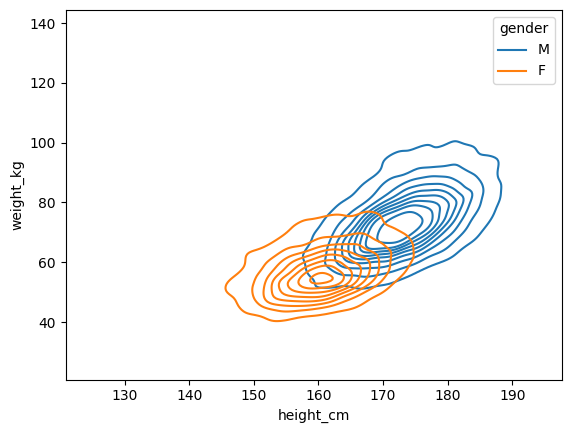

In [8]:
plt.figure()
sb.kdeplot(data=data[['weight_kg','height_cm','gender']],x='height_cm',y='weight_kg',hue='gender')

## 기본 가정
- 1. 정규성
- 2. 공분산 행렬의 동일
- 3. feature간 독립성

### 독립성 검증

In [9]:
import scipy as sp
import statsmodels.api as sm

VIF 이용

In [10]:
vif_columns=data.columns.difference(["gender","class"])

In [11]:
vif_result=[]
for col in vif_columns:
    model=sm.OLS(endog=data.loc[data["gender"]=="M",col]
                 ,exog=sm.add_constant(data.loc[data["gender"]=="M",[x for x in vif_columns if x!=col]])).fit()
    vif_result.append({'Col':col,'M_VIF':1/(1-model.rsquared)})
vif_result2=[]
for col in vif_columns:
    model=sm.OLS(endog=data.loc[data["gender"]=='F',col]
                 ,exog=sm.add_constant(data.loc[data["gender"]=='F',[x for x in vif_columns if x!=col]])).fit()
    vif_result2.append({'Col':col,'F_VIF':1/(1-model.rsquared)})

In [12]:
pd.merge(pd.DataFrame(vif_result),pd.DataFrame(vif_result2))

,Col,M_VIF,F_VIF
0,age,1.881921,2.198421
1,body fat_%,2.669772,2.717004
2,broad jump_cm,2.250784,2.561711
3,diastolic,1.747439,1.910566
4,gripForce,1.654977,1.677374
5,height_cm,2.089775,1.956360
6,sit and bend forward_cm,1.368062,1.342441
7,sit-ups counts,2.304430,2.659786
8,systolic,1.723448,2.108193
9,weight_kg,2.988957,2.721539


각 그룹간 VIF 값이 충분히 작음.         
따라서 feature 간 독립성 검정은 문제 없음

### 정규성
> 다변량 정규성을 확인해야함            
> 확실한 방법을 모르겠음...

### 공분산 행렬의 동일

### 모델

데이터 분할

In [13]:
import sklearn.model_selection as skmod
import sklearn.discriminant_analysis as skdis
import numpy as np
np.random.seed(10)

층화추출을 통한 부분 학습 방지

In [14]:
train,test=skmod.train_test_split(data,train_size=0.7,random_state=10,stratify=data["gender"])

In [15]:
model=skdis.LinearDiscriminantAnalysis(n_components=1)

In [16]:
model.fit(X=train[vif_columns],y=train["gender"])

LinearDiscriminantAnalysis(n_components=1)

In [17]:
import sklearn.metrics as skmet

훈련 데이터

In [18]:
skmet.accuracy_score(train['gender'],model.predict(train[vif_columns]))

0.9844266666666667

테스트 데이터

In [19]:
skmet.accuracy_score(test['gender'],model.predict(test[vif_columns]))

0.9853160776505724

위의 결과 과적합의 가능성이 있지만, 충분히 좋은 학습률을 보였기때문에 사용하기 좋다고 생각

#### 선형식 추출

In [20]:
# 계수
model.coef_

array([[ 0.14784164, -0.35866978,  0.07210858,  0.01941828,  0.23896367,
         0.05554243, -0.29820909,  0.03008185,  0.03150465,  0.22237803]])

In [21]:
# 상수
model.intercept_

array([-43.41235306])

위를 이용하면 차원감소를 시킬 수 있다

#### 참고
이게 eigen value를 나타내나, 크게 쓸모있진 않을것.          
    - 단, eigen value의 개수는 min(class 개수-1, featuer개수)

In [22]:
model.explained_variance_ratio_

array([1.])

### 이차판별분석

In [23]:
model2=skdis.QuadraticDiscriminantAnalysis()

In [24]:
model2.fit(X=train[vif_columns],y=train['gender'])

QuadraticDiscriminantAnalysis()

훈련데이터

In [25]:
skmet.accuracy_score(train['gender'],model2.predict(train[vif_columns]))

0.98464

In [26]:
skmet.accuracy_score(test['gender'],model2.predict(test[vif_columns]))

0.9863115978098557

현 상태에선 더 좋은 성능을 보이나, 계산량이 많다는 점을 고려하면 LDA와 QDA간의 차이를 잘 이해하여,          
모델을 select함이 필요할 것

### 차원축소

시각화 준비

In [27]:
model_transed=pd.DataFrame(model.decision_function(X=data[vif_columns])).rename(columns={0:'P1'})
model2_transed=pd.DataFrame(model2.decision_function(X=data[vif_columns])).rename(columns={0:'P2'})

In [28]:
value_data=pd.merge(model_transed,model2_transed,right_index=True,left_index=True)

In [29]:
target_data=pd.merge(pd.DataFrame(model.predict(data[vif_columns])),pd.DataFrame(model2.predict(data[vif_columns]))
                     ,right_index=True,left_index=True).rename(columns={'0_x':'Pred_model1',"0_y":'Pred_model2'})

In [30]:
pred_data=pd.merge(target_data,data["gender"],right_index=True,left_index=True)

In [31]:
final_data=pd.merge(value_data,pred_data,right_index=True,left_index=True)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sb

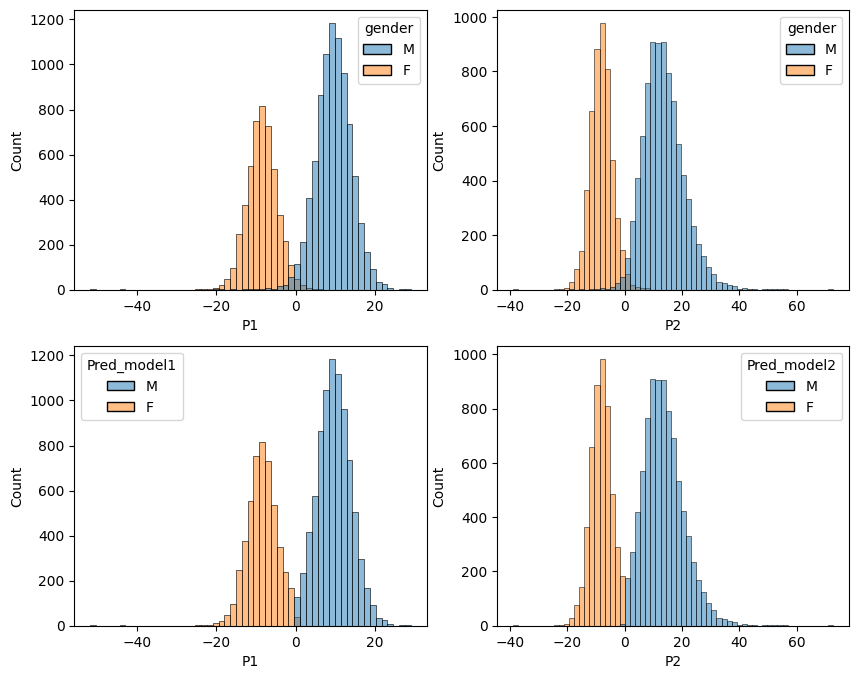

In [33]:
_,a=plt.subplots(2,2,figsize=(10,8))
sb.histplot(final_data,x="P1",hue="gender",ax=a[0][0])
sb.histplot(final_data,x="P2",hue="gender",ax=a[0][1])
sb.histplot(final_data,x="P1",hue="Pred_model1",ax=a[1][0])
sb.histplot(final_data,x="P2",hue="Pred_model2",ax=a[1][1])
plt.show()
plt.close()

#### 모델평가

In [35]:
test

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
7944,45.0,F,153.4,33.7,16.1,81.0,124.0,6.7,11.5,8.0,0.0,D
12632,26.0,M,168.8,64.0,33.6,75.0,118.0,50.5,26.6,51.0,234.0,A
2477,27.0,F,152.5,47.9,31.8,60.0,111.0,16.5,23.2,16.0,137.0,D
10508,34.0,M,167.3,76.0,27.6,81.0,135.0,35.5,13.0,46.0,239.0,D
6062,43.0,F,162.5,64.8,33.7,93.0,132.0,28.6,14.6,23.0,126.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
655,39.0,M,184.4,85.7,18.5,92.0,138.0,49.8,13.7,46.0,223.0,D
6073,35.0,F,162.0,53.0,24.7,68.0,107.0,29.1,21.4,40.0,155.0,B
11902,51.0,M,173.8,68.7,17.8,91.0,138.0,38.3,11.2,38.0,223.0,B
6797,24.0,F,163.3,51.3,26.4,77.0,114.0,23.4,21.6,35.0,161.0,B


In [36]:
print(skmet.classification_report(y_true=test["gender"],y_pred=model2.predict(test[vif_columns])))

              precision    recall  f1-score   support

           F       0.98      0.98      0.98      1478
           M       0.99      0.99      0.99      2540

    accuracy                           0.99      4018
   macro avg       0.98      0.99      0.99      4018
weighted avg       0.99      0.99      0.99      4018

